In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, LayerNormalization, Dropout, MultiHeadAttention,Add,GRU,BatchNormalization
from tensorflow.keras.layers import Layer
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import Reshape


In [3]:
# Load all the data.
df=pd.read_csv("C:/Users/Aneesa/Downloads/Transactions.csv")

In [5]:
df.shape

(1339796, 46)

In [7]:
df.shape

(1339796, 46)

In [9]:
selected_cols_for_desc = ['procedure_area', 'actual_worth', 'meter_sale_price','has_parking']

round(df[selected_cols_for_desc].describe().T, 2)

,count,mean,std,min,25%,50%,75%,max
procedure_area,1339796.0,1410.59,316564.87,0.01,70.59,117.30,235.77,3.421034e+08
actual_worth,1339796.0,3962015.78,66242088.67,1.00,720667.00,1313287.00,2432100.00,1.378694e+10
meter_sale_price,1339796.0,14359.93,132191.49,0.00,6762.65,10344.66,15875.21,8.125000e+07
has_parking,1339796.0,0.64,0.48,0.00,0.00,1.00,1.00,1.000000e+00


In [11]:
# Sample Data Preprocessing
columns = [
    'has_parking',
    'meter_sale_price',
    'no_of_parties_role_1',
    'no_of_parties_role_2',
    'no_of_parties_role_3',
    'procedure_area',
    'property_type_en',
    'property_sub_type_en',
    'reg_type_en',
    'property_usage_en',
    'rooms_en',
    'trans_group_en',
    'actual_worth'
]

In [13]:
df = df[columns].sample(frac=0.05, random_state=42)

In [15]:
# Handling outliers with IQR method
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)

In [17]:
# Apply to numerical columns
handle_outliers(df, 'actual_worth')
handle_outliers(df, 'meter_sale_price')
handle_outliers(df, 'procedure_area')

In [19]:
df['has_parking'].isna().any()

False

In [21]:
df.columns[df.isna().any()]

Index(['no_of_parties_role_1', 'no_of_parties_role_2', 'no_of_parties_role_3',
       'property_sub_type_en', 'rooms_en'],
      dtype='object')

In [23]:
# Fill missing values for categorical features
df['rooms_en'] = df['rooms_en'].fillna('N/A')
df['property_sub_type_en'] = df['property_sub_type_en'].fillna('N/A')
df['no_of_parties_role_1'] = df['no_of_parties_role_1'].fillna('N/A')
df['no_of_parties_role_2'] = df['no_of_parties_role_2'].fillna('N/A')
df['no_of_parties_role_3'] = df['no_of_parties_role_3'].fillna('N/A')
df.dropna(inplace=True)

C:\Users\Aneesa\AppData\Local\Temp\ipykernel_14724\140894991.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'has_parking', y="meter_sale_price",data=df, palette='viridis')


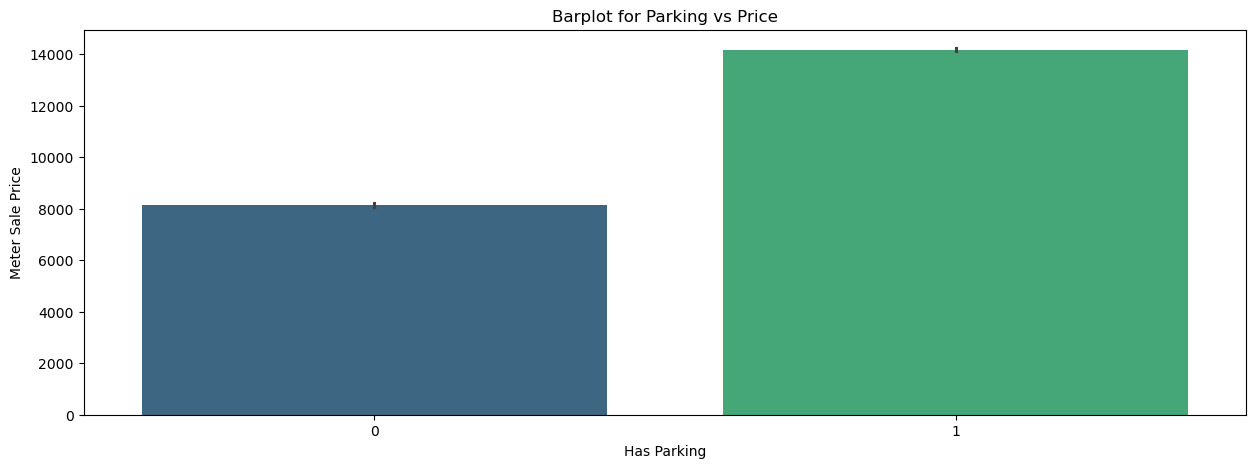

In [25]:
plt.figure(figsize=(15,5))
sns.barplot(x = 'has_parking', y="meter_sale_price",data=df, palette='viridis')
plt.title(f'Barplot for Parking vs Price')
plt.xlabel('Has Parking')
plt.ylabel('Meter Sale Price')
plt.show()

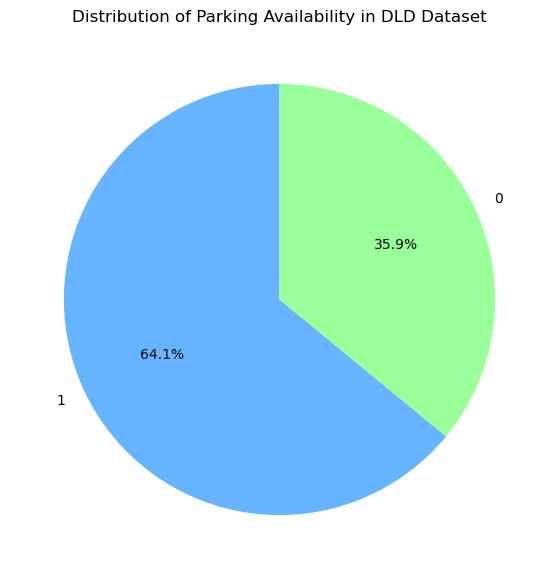

In [111]:
# Check the distribution of the 'has_parking' column
parking_counts = df['has_parking'].value_counts()

# Plot the pie chart
plt.figure(figsize=(7, 7))
plt.pie(parking_counts, labels=parking_counts.index, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#99ff99'])
plt.title('Distribution of Parking Availability in DLD Dataset')
plt.show()

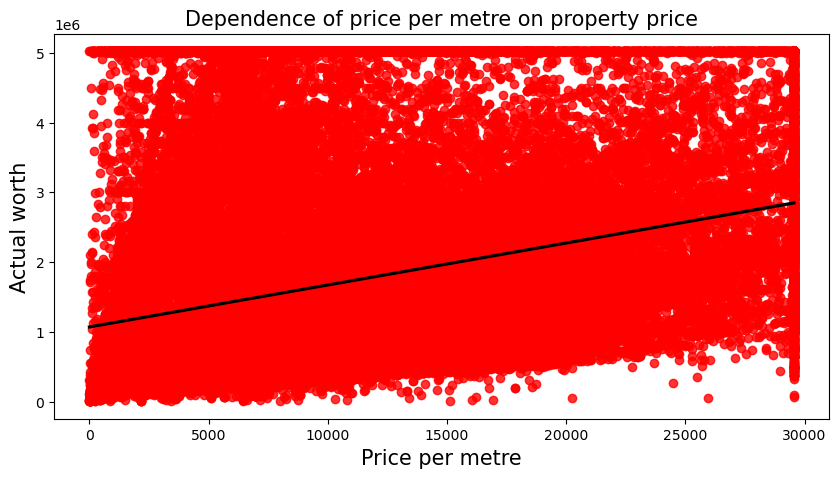

In [117]:
plt.figure(figsize=(10,5))

ax = sns.regplot(x = 'meter_sale_price' , y = 'actual_worth', data = df, fit_reg= True, scatter_kws= {'color':'red'}, line_kws={'color':'black'})
plt.title('Dependence of price per metre on property price',fontsize=15)
plt.xlabel('Price per metre',fontsize=15)
plt.ylabel('Actual worth',fontsize=15)
plt.show()

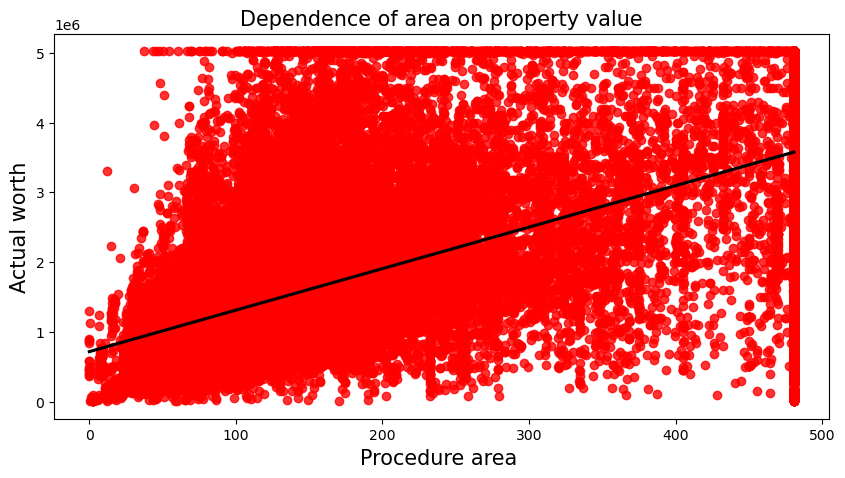

In [119]:
plt.figure(figsize=(10,5))
ax = sns.regplot(x = 'procedure_area' , y = 'actual_worth', data = df, fit_reg= True, scatter_kws= {'color':'red'}, line_kws={'color':'black'})

plt.title('Dependence of area on property value',fontsize=15)
plt.xlabel('Procedure area ',fontsize=15)
plt.ylabel('Actual worth',fontsize=15)
plt.show()

C:\Users\Aneesa\AppData\Local\Temp\ipykernel_12160\65553128.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'property_sub_type_en' , y='actual_worth', data=df, palette='viridis')


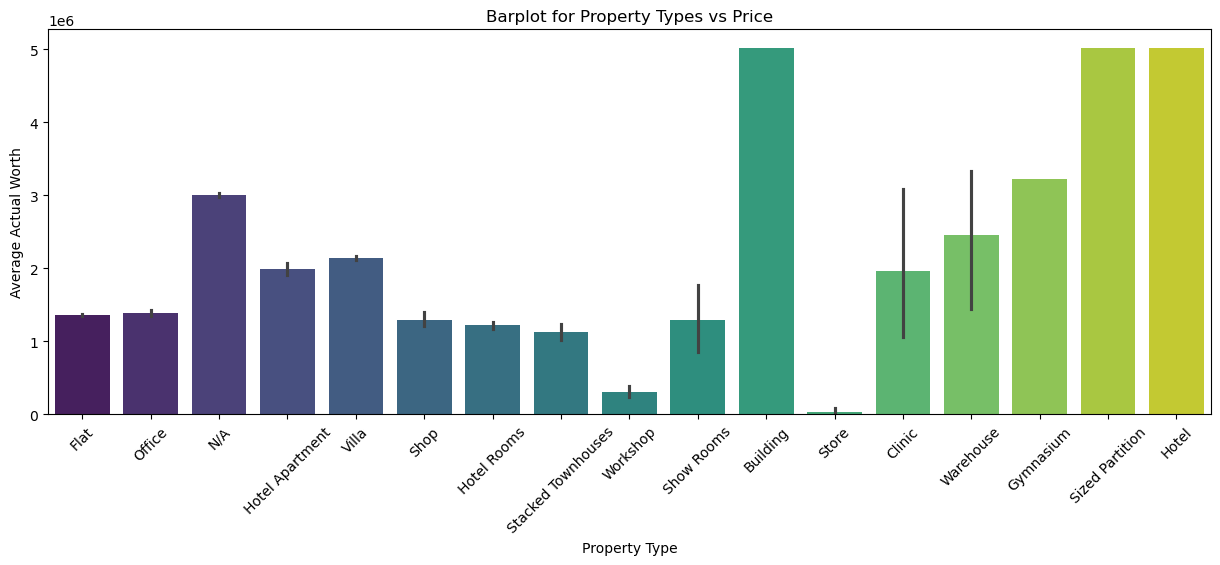

In [123]:
plt.figure(figsize=(15,5))
sns.barplot(x = 'property_sub_type_en' , y='actual_worth', data=df, palette='viridis')
plt.title(f'Barplot for Property Types vs Price')
plt.xlabel('Property Type')
plt.ylabel('Average Actual Worth')
plt.xticks(rotation=45)
plt.show()

C:\Users\Aneesa\AppData\Local\Temp\ipykernel_12160\1122538888.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'property_usage_en' , y='actual_worth', data=df, palette='viridis')


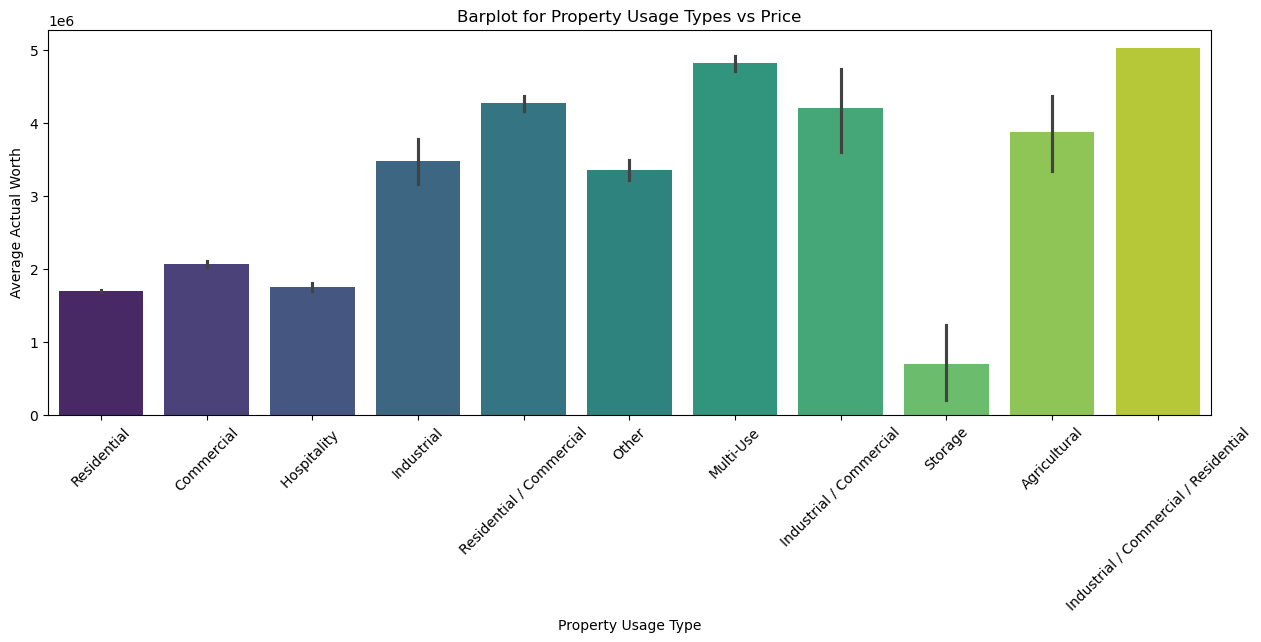

In [127]:
plt.figure(figsize=(15,5))
sns.barplot(x = 'property_usage_en' , y='actual_worth', data=df, palette='viridis')
plt.title(f'Barplot for Property Usage Types vs Price')
plt.xlabel('Property Usage Type')
plt.ylabel('Average Actual Worth')
plt.xticks(rotation=45)
plt.show()

C:\Users\Aneesa\AppData\Local\Temp\ipykernel_12160\1134358250.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'reg_type_en' , y='actual_worth', data=df, palette='viridis')


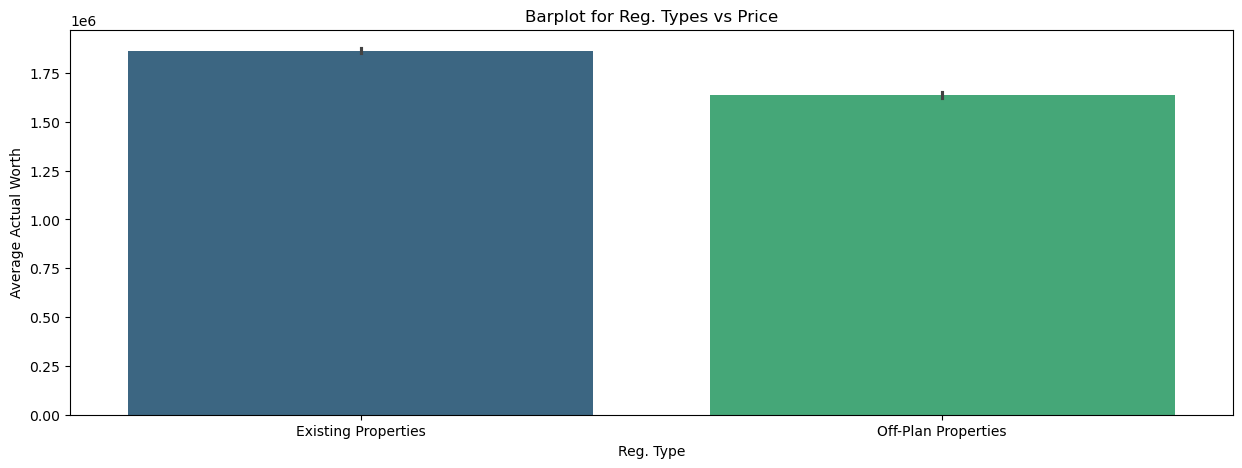

In [129]:
plt.figure(figsize=(15,5))
sns.barplot(x = 'reg_type_en' , y='actual_worth', data=df, palette='viridis')
plt.title(f'Barplot for Reg. Types vs Price')
plt.xlabel('Reg. Type')
plt.ylabel('Average Actual Worth')
plt.show()

C:\Users\Aneesa\AppData\Local\Temp\ipykernel_12160\321845173.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'rooms_en' , y='actual_worth', data=df, palette='viridis')


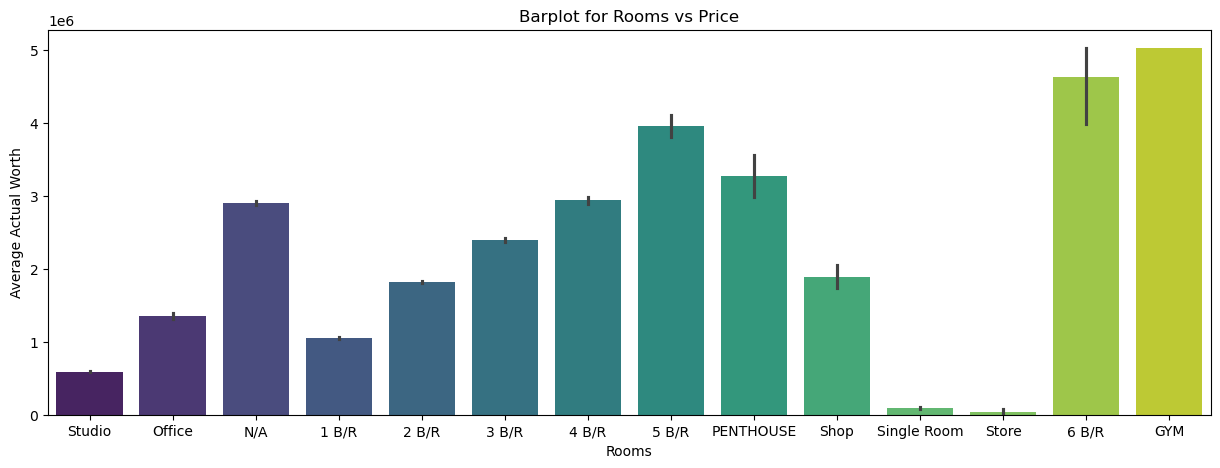

In [131]:
# Построение bar plot для визуализации распределения количества комнат в собственности с целевой переменной цены недвижимости
plt.figure(figsize=(15,5))
sns.barplot(x = 'rooms_en' , y='actual_worth', data=df, palette='viridis')
plt.title(f'Barplot for Rooms vs Price')
plt.xlabel('Rooms')
plt.ylabel('Average Actual Worth')
plt.show()

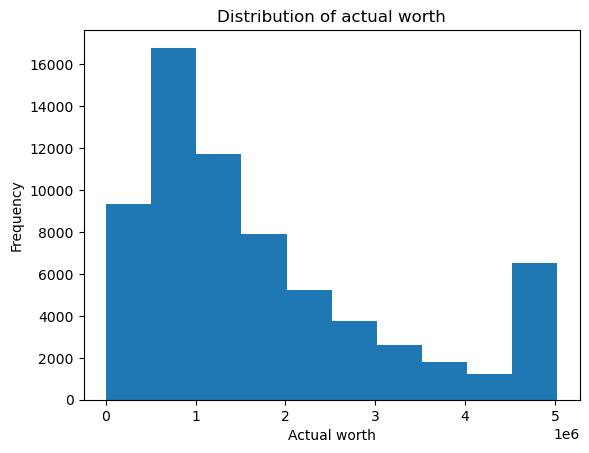

In [137]:
df["actual_worth"].plot(kind='hist')
plt.title('Distribution of actual worth')
plt.xlabel('Actual worth')
plt.show()

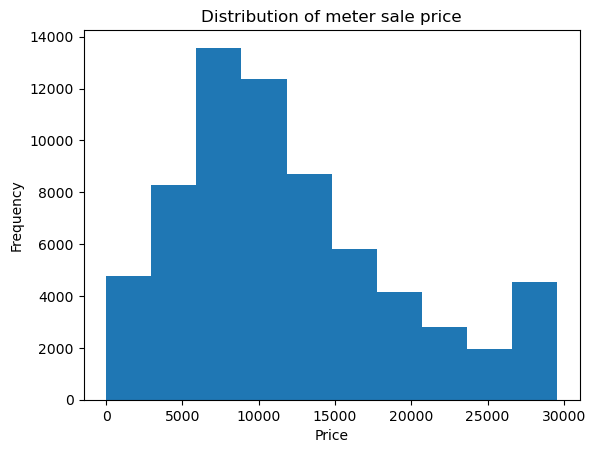

In [139]:
df["meter_sale_price"].plot(kind='hist')
plt.title('Distribution of meter sale price')
plt.xlabel('Price')
plt.show()

In [19]:
# Handling categorical data
categorical_columns = [
    'property_type_en',
    'property_sub_type_en',
    'reg_type_en',
    'property_usage_en',
    'rooms_en',
    'trans_group_en'
]

In [21]:
# Encode categorical features
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [23]:
# Split features and target
X = df.drop('actual_worth', axis=1)
y = df['actual_worth']

In [25]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Identify categorical and numerical features
numerical_features = ['meter_sale_price', 'procedure_area', 'no_of_parties_role_1', 'no_of_parties_role_2', 'no_of_parties_role_3']
categorical_features = [col for col in categorical_columns if col in X.columns]


Transformer Model

In [58]:
# Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-Head Attention
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x + inputs)

    # Feed Forward
    x_ff = Dense(ff_dim, activation='relu')(x)
    x_ff = Dense(inputs.shape[-1])(x_ff)
    x_ff = Dropout(dropout)(x_ff)
    return LayerNormalization(epsilon=1e-6)(x + x_ff)


In [60]:
# Input layers
inputs = []
encoded_features = []

In [62]:
# Process numerical inputs
for col in numerical_features:
    num_input = Input(shape=(1,), name=col)
    inputs.append(num_input)
    encoded_features.append(num_input)

In [64]:
# Process categorical inputs
for col in categorical_features:
    vocab_size = df[col].nunique()
    embed_dim = int(np.ceil(np.log2(vocab_size)))
    cat_input = Input(shape=(1,), name=col)
    embedding = Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=1)(cat_input)
    flatten = Flatten()(embedding)
    inputs.append(cat_input)
    encoded_features.append(flatten)


C:\Users\Aneesa\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [66]:
# Concatenate all features
concat_features = Concatenate()(encoded_features)

In [68]:
# Reshape features for Transformer input (timesteps=1, features=N)
reshaped_features = tf.keras.layers.Reshape((1, concat_features.shape[1]))(concat_features)

In [70]:
# Transformer Encoder
transformer_output = transformer_encoder(reshaped_features, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)

In [72]:
# Flatten the Transformer output
flatten_transformer = tf.keras.layers.Flatten()(transformer_output)

In [74]:
# Fully connected layers for regression
dense = Dense(128, activation='relu')(flatten_transformer)
dense = Dense(64, activation='relu')(dense)
output = Dense(1)(dense)

In [76]:
# Build and compile the model
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

In [78]:
# Prepare inputs for the model
def prepare_model_inputs(X, categorical_features, numerical_features):
    model_inputs = {}
    for col in categorical_features + numerical_features:
        model_inputs[col] = X[col].values
    return model_inputs

train_inputs = prepare_model_inputs(X_train, categorical_features, numerical_features)
test_inputs = prepare_model_inputs(X_test, categorical_features, numerical_features)

In [80]:
# Train the model
history = model.fit(
    train_inputs, y_train,
    validation_data=(test_inputs, y_test),
    epochs=80,
    batch_size=256,
    verbose=1
)

Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - loss: 5211853684736.0000 - mae: 1790042.6250 - val_loss: 5241184976896.0000 - val_mae: 1793420.7500
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 5156083073024.0000 - mae: 1777548.2500 - val_loss: 5009444962304.0000 - val_mae: 1727734.0000
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 4833510686720.0000 - mae: 1683034.7500 - val_loss: 4177556668416.0000 - val_mae: 1475324.0000
Epoch 4/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 3822783299584.0000 - mae: 1378820.2500 - val_loss: 2878545068032.0000 - val_mae: 1139532.3750
Epoch 5/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 2629246648320.0000 - mae: 1106077.0000 - val_loss: 2118167035904.0000 - val_mae: 1070765.2500
Epoch 6/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 2010564788224.0000 - mae: 1061390.5000 - val_loss: 2001055645696.0000 - val_mae: 1109906.8750
Epoch 7/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 180

In [82]:
# Predictions and Evaluation
y_pred = model.predict(test_inputs).flatten()


419/419 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step


In [83]:
# Calculate metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.5f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

R² Score: 0.94114
Mean Absolute Error (MAE): 153204.39
Root Mean Squared Error (RMSE): 345240.38


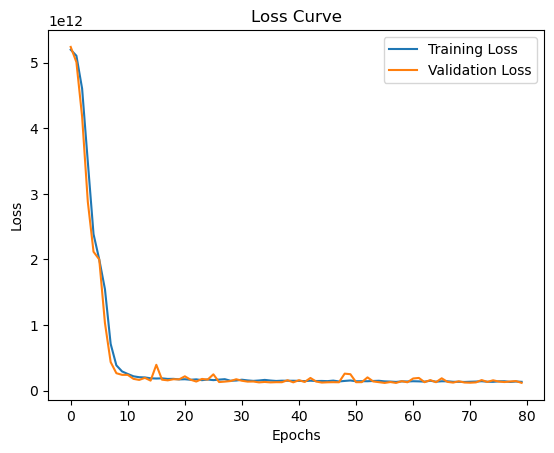

In [86]:
# Plot loss over epochs with labeled axes
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')  # Label for x-axis
plt.ylabel('Loss')    # Label for y-axis
plt.legend()
plt.title('Loss Curve')
plt.show()

TabTransformer Model

In [269]:
# TabTransformer Encoder Block
def tab_transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x + inputs)
    
    x_ff = Dense(ff_dim, activation='relu')(x)
    x_ff = Dense(inputs.shape[-1])(x_ff)
    x_ff = Dropout(dropout)(x_ff)
    
    return LayerNormalization(epsilon=1e-6)(x + x_ff)


In [271]:
# Input layers
inputs = []
embedded_features = []

In [273]:
# Process categorical inputs
for col in categorical_features:
    vocab_size = df[col].nunique()
    embed_dim = int(np.ceil(np.log2(vocab_size)))
    cat_input = Input(shape=(1,), name=col)
    embedding = Embedding(input_dim=vocab_size, output_dim=embed_dim)(cat_input)
    embedded_features.append(embedding)
    inputs.append(cat_input)

In [275]:
# Process numerical inputs
for col in numerical_features:
    num_input = Input(shape=(1,), name=col)
    embedded_features.append(tf.keras.layers.Reshape((1, 1))(num_input))  # Reshape to align with embeddings
    inputs.append(num_input)

In [277]:
# Concatenate all features
all_features = Concatenate()(embedded_features)

In [279]:
# TabTransformer Encoder
transformer_output = tab_transformer_block(all_features, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)


In [281]:
# Flatten Transformer output
flatten_transformer = Flatten()(transformer_output)


In [283]:
# Fully connected layers for regression
dense = Dense(128, activation='relu')(flatten_transformer)
dense = Dense(64, activation='relu')(dense)
output = Dense(1)(dense)

In [285]:
# Build and compile the model
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])


In [287]:
# Prepare inputs for the model
def prepare_model_inputs(X, categorical_features, numerical_features):
    model_inputs = {}
    for col in categorical_features + numerical_features:
        model_inputs[col] = X[col].values
    return model_inputs

train_inputs = prepare_model_inputs(X_train, categorical_features, numerical_features)
test_inputs = prepare_model_inputs(X_test, categorical_features, numerical_features)


In [289]:
# Train the model
history = model.fit(
    train_inputs, y_train,
    validation_data=(test_inputs, y_test),
    epochs=80,
    batch_size=256,
    verbose=1
)

Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - loss: 5246241734656.0000 - mae: 1798419.7500 - val_loss: 5230416101376.0000 - val_mae: 1790416.8750
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 5106632228864.0000 - mae: 1765709.5000 - val_loss: 4854692970496.0000 - val_mae: 1682598.3750
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 4563795443712.0000 - mae: 1604111.8750 - val_loss: 3644610838528.0000 - val_mae: 1317834.8750
Epoch 4/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 3217533435904.0000 - mae: 1217177.6250 - val_loss: 2334012997632.0000 - val_mae: 1070249.6250
Epoch 5/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 2136913084416.0000 - mae: 1051617.3750 - val_loss: 2012017328128.0000 - val_mae: 1107574.7500
Epoch 6/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 1932473270272.0000 - mae: 1076579.8750 - val_loss: 1276364980224.0000 - val_mae: 725622.0000
Epoch 7/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 1097

In [291]:
# Predictions and Evaluation
y_pred = model.predict(test_inputs).flatten()


419/419 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


In [292]:
# Calculate metrics
tab_r2 = r2_score(y_test, y_pred)
tab_mae = mean_absolute_error(y_test, y_pred)
tab_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {tab_r2:.5f}")
print(f"Mean Absolute Error (MAE): {tab_mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {tab_rmse:.2f}")

R² Score: 0.94123
Mean Absolute Error (MAE): 159078.81
Root Mean Squared Error (RMSE): 344958.34


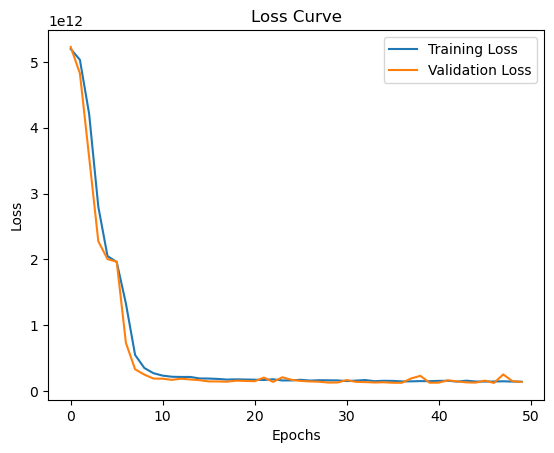

In [88]:
# Plot loss over epochs with x-axis and y-axis labeled
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')  # Label for x-axis
plt.ylabel('Loss')    # Label for y-axis
plt.legend()
plt.title('Loss Curve')
plt.show()

FT-Transformer Model 

In [88]:
# Input layers
inputs = []
encoded_features = []


In [90]:
# Process numerical inputs
for col in numerical_features:
    num_input = Input(shape=(1,), name=col)
    inputs.append(num_input)
    encoded_features.append(num_input)

In [92]:
# Process categorical inputs
for col in categorical_features:
    vocab_size = df[col].nunique()
    embed_dim = int(np.ceil(np.log2(vocab_size)))
    cat_input = Input(shape=(1,), name=col)
    embedding = Embedding(input_dim=vocab_size, output_dim=embed_dim)(cat_input)
    flatten = Flatten()(embedding)
    inputs.append(cat_input)
    encoded_features.append(flatten)

In [94]:
# Concatenate all tokens
concat_tokens = Concatenate()(encoded_features)

In [100]:
# Reshape for Transformer Input (timesteps=1, features=N)
reshaped_tokens = Reshape((1, concat_tokens.shape[1]))(concat_tokens)

In [102]:
# Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x + inputs)
    x_ff = Dense(ff_dim, activation="relu")(x)
    x_ff = Dense(inputs.shape[-1])(x_ff)
    x_ff = Dropout(dropout)(x_ff)
    return LayerNormalization(epsilon=1e-6)(x + x_ff)


In [104]:
# Add Positional Encoding
positional_encoding = Dense(reshaped_tokens.shape[-1], activation="relu")(reshaped_tokens)

In [106]:
# Pass through Transformer Encoder
transformer_output = transformer_encoder(
    inputs=positional_encoding,
    head_size=64,
    num_heads=4,
    ff_dim=128,
    dropout=0.1
)

In [108]:
# Flatten the Transformer output
flattened_output = Flatten()(transformer_output)

In [110]:
# Fully connected layers for regression
dense = Dense(128, activation="relu")(flattened_output)
dense = Dropout(0.1)(dense)
dense = Dense(64, activation="relu")(dense)
output = Dense(1, activation="linear")(dense)

In [112]:
# Build and compile the model
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics=["mae"])

In [114]:
# Prepare inputs for the model
def prepare_model_inputs(X, categorical_features, numerical_features):
    model_inputs = {}
    for col in categorical_features + numerical_features:
        model_inputs[col] = X[col].values
    return model_inputs

train_inputs = prepare_model_inputs(X_train, categorical_features, numerical_features)
test_inputs = prepare_model_inputs(X_test, categorical_features, numerical_features)

In [116]:
# Train the model
history = model.fit(
    train_inputs, y_train,
    validation_data=(test_inputs, y_test),
    epochs=80,
    batch_size=256,
    verbose=1
)

Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - loss: 5233530372096.0000 - mae: 1796872.0000 - val_loss: 5231858941952.0000 - val_mae: 1790819.8750
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 5116545990656.0000 - mae: 1766750.5000 - val_loss: 4880457531392.0000 - val_mae: 1690190.5000
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 4619306532864.0000 - mae: 1620151.8750 - val_loss: 3732068368384.0000 - val_mae: 1342400.0000
Epoch 4/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 3301509693440.0000 - mae: 1238786.1250 - val_loss: 2401196834816.0000 - val_mae: 1073742.0000
Epoch 5/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 2212351705088.0000 - mae: 1061626.3750 - val_loss: 2022857113600.0000 - val_mae: 1095613.3750
Epoch 6/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 1972019527680.0000 - mae: 1097286.2500 - val_loss: 1971499696128.0000 - val_mae: 1098073.7500
Epoch 7/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 18104

In [118]:
# Predictions and Evaluation
y_pred = model.predict(test_inputs).flatten()

419/419 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step


In [120]:
# Calculate metrics
ft_r2 = r2_score(y_test, y_pred)
ft_mae = mean_absolute_error(y_test, y_pred)
ft_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {ft_r2:.5f}")
print(f"Mean Absolute Error (MAE): {ft_mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {ft_rmse:.2f}")

R² Score: 0.93220
Mean Absolute Error (MAE): 192833.38
Root Mean Squared Error (RMSE): 370530.96


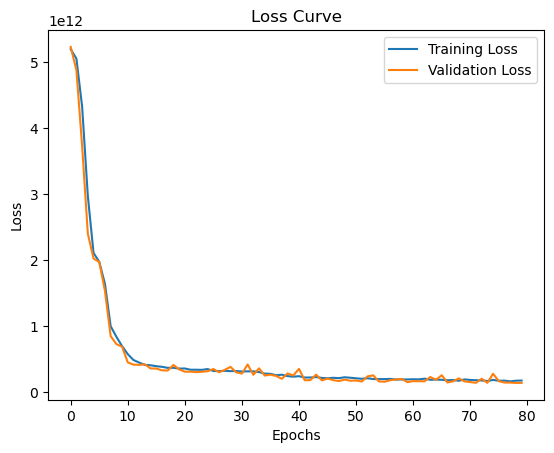

In [122]:
# Plot loss over epochs with labeled axes
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')  # Label for the x-axis
plt.ylabel('Loss')    # Label for the y-axis
plt.legend()
plt.title('Loss Curve')
plt.show()

Gated Recurrent Unit(GRU) Model

In [212]:
# Input layers
inputs = []
encoded_features = []

In [214]:
# Process numerical inputs
for col in numerical_features:
    num_input = Input(shape=(1,), name=col)
    inputs.append(num_input)
    encoded_features.append(num_input)

In [216]:
# Process categorical inputs
for col in categorical_features:
    vocab_size = df[col].nunique()
    embed_dim = int(np.ceil(np.log2(vocab_size)))
    cat_input = Input(shape=(1,), name=col)
    embedding = Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=1)(cat_input)
    flatten = Flatten()(embedding)
    inputs.append(cat_input)
    encoded_features.append(flatten)

C:\Users\Aneesa\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [218]:
# Concatenate all features
concat_features = Concatenate()(encoded_features)

In [220]:
# Reshaping the concatenated features to simulate sequential input for GRU
# Adding the 'timesteps' dimension using Reshape layer
reshaped_features = tf.keras.layers.Reshape((1, concat_features.shape[1]))(concat_features)  # Shape: (batch_size, 1, features)

In [222]:
# GRU layer for sequential modeling
gru_output = GRU(64, activation='relu', return_sequences=False)(reshaped_features)  # GRU layer
gru_output = BatchNormalization()(gru_output)

In [224]:
# Deep part after GRU
deep = Dense(128, activation='relu')(gru_output)
deep = Dense(64, activation='relu')(deep)

In [226]:
# Output layer
output = Dense(1)(deep)

In [228]:
# Build and compile the model
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])


In [230]:
# Prepare inputs for the model
def prepare_model_inputs(X, categorical_features, numerical_features):
    model_inputs = {}
    for col in categorical_features + numerical_features:
        model_inputs[col] = X[col].values
    return model_inputs

train_inputs = prepare_model_inputs(X_train, categorical_features, numerical_features)
test_inputs = prepare_model_inputs(X_test, categorical_features, numerical_features)

In [232]:
# Train the model
history = model.fit(
    train_inputs, y_train,
    validation_data=(test_inputs, y_test),
    epochs=100,
    batch_size=256,
    verbose=1
)

Epoch 1/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 5254542786560.0000 - mae: 1799882.2500 - val_loss: 5235380584448.0000 - val_mae: 1792515.5000
Epoch 2/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 5070292254720.0000 - mae: 1760240.8750 - val_loss: 4756348600320.0000 - val_mae: 1664796.5000
Epoch 3/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4278627598336.0000 - mae: 1568209.1250 - val_loss: 2709025980416.0000 - val_mae: 1103552.3750
Epoch 4/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1928136228864.0000 - mae: 914369.6875 - val_loss: 1117139369984.0000 - val_mae: 750620.0625
Epoch 5/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 540730785792.0000 - mae: 511220.9062 - val_loss: 467592871936.0000 - val_mae: 471694.0312
Epoch 6/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 337011310592.0000 - mae: 403781.2812 - val_loss: 286321016832.0000 - val_mae: 346686.7500
Epoch 7/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 27963906457

In [235]:
# Predictions and Evaluation
y_pred = model.predict(test_inputs).flatten()

419/419 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


In [236]:
# Calculate metrics
gru_r2 = r2_score(y_test, y_pred)
gru_mae = mean_absolute_error(y_test, y_pred)
gru_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {gru_r2:.5f}")
print(f"Mean Absolute Error (MAE): {gru_mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {gru_rmse:.2f}")

R² Score: 0.92737
Mean Absolute Error (MAE): 202045.60
Root Mean Squared Error (RMSE): 383484.41


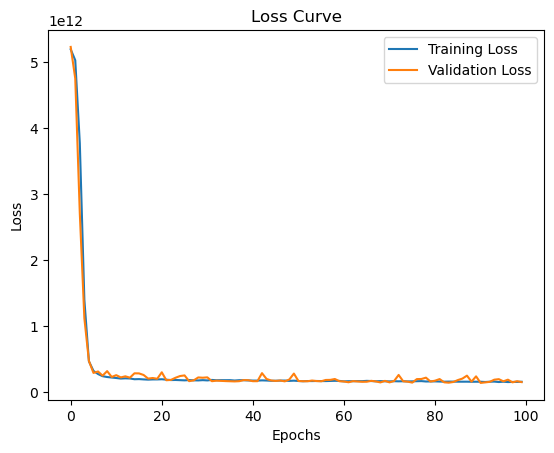

In [239]:
# Plot loss over epochs with axis labels
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')  # Label for the x-axis
plt.ylabel('Loss')    # Label for the y-axis
plt.legend()
plt.title('Loss Curve')
plt.show()

Deep and Cross Network(DCN) Model

In [182]:
# DCN Implementation
class CrossLayer(Layer):
    def __init__(self, num_features, **kwargs):
        super(CrossLayer, self).__init__(**kwargs)
        self.num_features = num_features

    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(self.num_features, 1),
            initializer="glorot_uniform",
            trainable=True
        )
        self.bias = self.add_weight(
            shape=(self.num_features,),
            initializer="zeros",
            trainable=True
        )

    def call(self, inputs):
        x_0, x_l = inputs
        x_cross = tf.matmul(tf.expand_dims(x_l, -1), tf.expand_dims(x_0, 1))
        x_cross = tf.reduce_sum(x_cross * self.kernel, axis=-1) + self.bias + x_l
        return x_cross

In [184]:
# Input layers
inputs = []
encoded_features = []

In [186]:
# Process numerical inputs
for col in numerical_features:
    num_input = Input(shape=(1,), name=col)
    inputs.append(num_input)
    encoded_features.append(num_input)


In [188]:
# Process categorical inputs
for col in categorical_features:
    vocab_size = df[col].nunique()
    embed_dim = int(np.ceil(np.log2(vocab_size)))
    cat_input = Input(shape=(1,), name=col)
    embedding = Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=1)(cat_input)
    flatten = Flatten()(embedding)
    inputs.append(cat_input)
    encoded_features.append(flatten)


C:\Users\Aneesa\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [190]:
# Concatenate all features
concat_features = Concatenate()(encoded_features)


In [192]:
# Deep part
deep = Dense(128, activation='relu')(concat_features)
deep = Dense(64, activation='relu')(deep)

In [194]:
# Cross part
cross = CrossLayer(concat_features.shape[1])(inputs=[concat_features, concat_features])

In [196]:
# Combine deep and cross parts
combined = Concatenate()([deep, cross])
output = Dense(1)(combined)

In [198]:
# Build and compile the model
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [200]:
# Prepare inputs for the model
def prepare_model_inputs(X, categorical_features, numerical_features):
    model_inputs = {}
    for col in categorical_features + numerical_features:
        model_inputs[col] = X[col].values
    return model_inputs

train_inputs = prepare_model_inputs(X_train, categorical_features, numerical_features)
test_inputs = prepare_model_inputs(X_test, categorical_features, numerical_features)


In [202]:
# Train the model
history = model.fit(
    train_inputs, y_train,
    validation_data=(test_inputs, y_test),
    epochs=100,
    batch_size=256,
    verbose=1
)

Epoch 1/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 3817983442944.0000 - mae: 1285019.0000 - val_loss: 1679651766272.0000 - val_mae: 849902.5000
Epoch 2/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1317977456640.0000 - mae: 735962.3750 - val_loss: 818001674240.0000 - val_mae: 550235.9375
Epoch 3/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 772008574976.0000 - mae: 532546.5000 - val_loss: 699003895808.0000 - val_mae: 492361.0938
Epoch 4/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 694568943616.0000 - mae: 483801.4375 - val_loss: 657579573248.0000 - val_mae: 460565.7500
Epoch 5/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 642922840064.0000 - mae: 454876.3438 - val_loss: 611527294976.0000 - val_mae: 440110.5938
Epoch 6/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 580372725760.0000 - mae: 434899.2188 - val_loss: 554405658624.0000 - val_mae: 416192.1875
Epoch 7/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 526637858816.0000 - ma

In [206]:
# Predictions and Evaluation
y_pred = model.predict(test_inputs).flatten()

419/419 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


In [208]:
dcn_r2 = r2_score(y_test, y_pred)
dcn_mae = mean_absolute_error(y_test, y_pred)
dcn_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {dcn_r2:.5f}")
print(f"Mean Absolute Error (MAE): {dcn_mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {dcn_rmse:.2f}")


R² Score: 0.90258
Mean Absolute Error (MAE): 247148.87
Root Mean Squared Error (RMSE): 444135.81


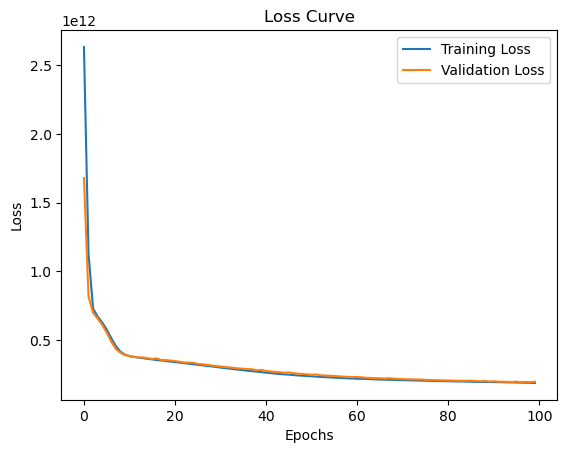

In [210]:
# Plot loss over epochs with axis labels
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')  # Label for the x-axis
plt.ylabel('Loss')    # Label for the y-axis
plt.legend()
plt.title('Loss Curve')
plt.show()

SHOWING R-SQUARED, RMSE, MAE VALUES OF EACH MODELS IN A TABLE

In [295]:
# Placeholder for metrics of different models
metrics = {
    "Model": ["Transformer", "TabTransformer", "FT-Transformer", 
              "GRU", "DCN"],
    "R-Squared": [r2, tab_r2, ft_r2, gru_r2, dcn_r2],
    "RMSE": [rmse, tab_rmse, ft_rmse, gru_rmse, dcn_rmse],
    "MAE": [mae, tab_mae, ft_mae, gru_mae, dcn_mae]
}

In [299]:
# Create a DataFrame
metrics_df = pd.DataFrame(metrics)

In [301]:
# Print the DataFrame as a table
print(metrics_df)


            Model  R-Squared           RMSE            MAE
0     Transformer   0.941135  345240.380448  153204.390948
1  TabTransformer   0.941231  344958.337687  159078.810794
2  FT-Transformer   0.932195  370530.961886  192833.382783
3             GRU   0.927371  383484.412199  202045.598969
4             DCN   0.902581  444135.805982  247148.865981
